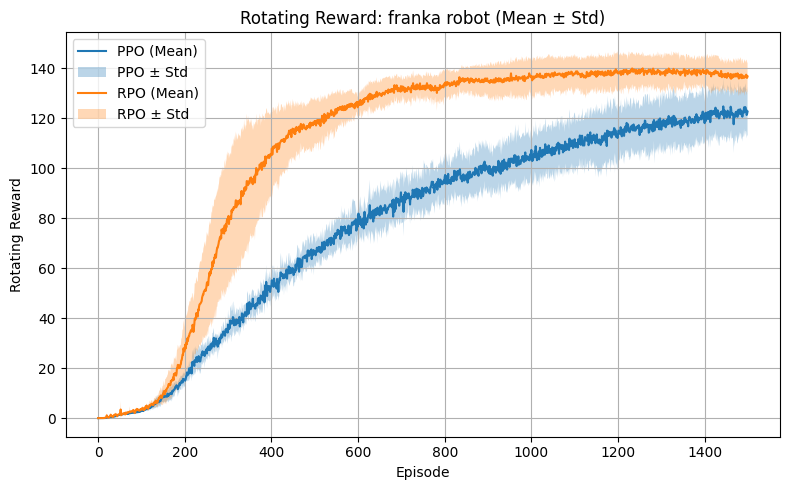

Figure saved as rotating_reward_franka_robot.png


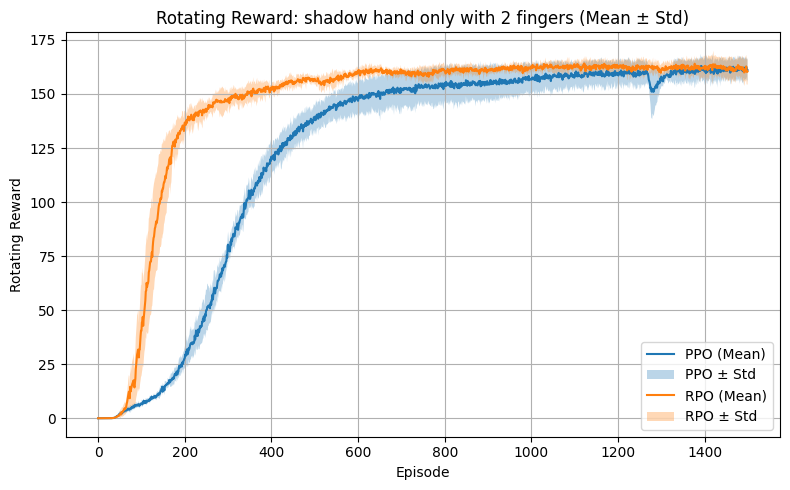

Figure saved as rotating_reward_shadow_hand_only_with_2_fingers.png


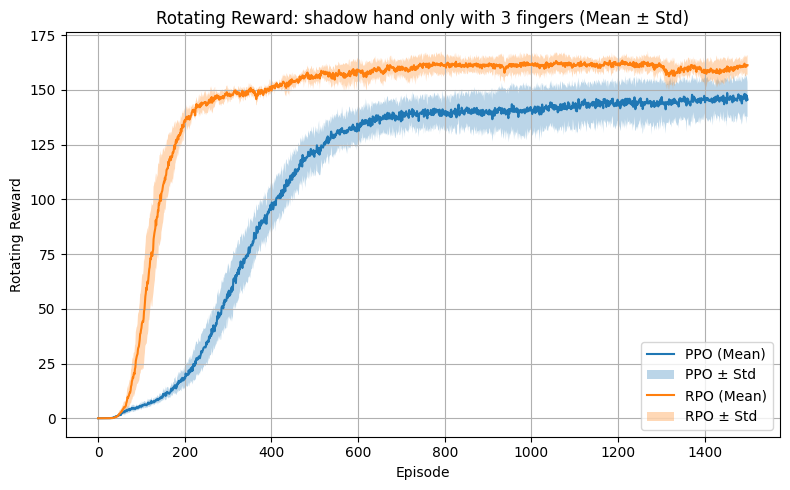

Figure saved as rotating_reward_shadow_hand_only_with_3_fingers.png


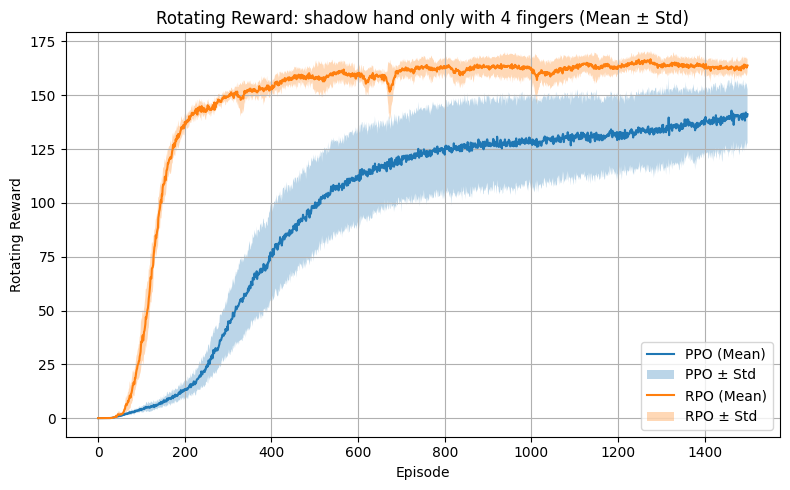

Figure saved as rotating_reward_shadow_hand_only_with_4_fingers.png


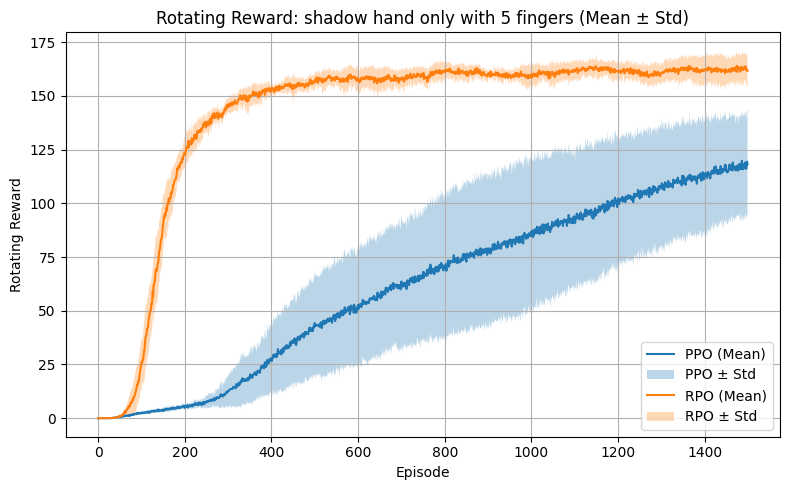

Figure saved as rotating_reward_shadow_hand_only_with_5_fingers.png


In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

log_dir = "./" 

patterns = {
    'franka robot': {
        'PPO': r'train_.*_franka\.log',
        'RPO': r'train_.*_franka_skrl\.log',
    },
    'shadow hand only with 2 fingers': {
        'PPO': r'train_.*_shadow2\.log',
        'RPO': r'train_.*_shadow2_skrl\.log',
    },
    'shadow hand only with 3 fingers': {
        'PPO': r'train_.*_shadow3\.log',
        'RPO': r'train_.*_shadow3_skrl\.log',
    },
    'shadow hand only with 4 fingers': {
        'PPO': r'train_.*_shadow4\.log',
        'RPO': r'train_.*_shadow4_skrl\.log',
    },
    'shadow hand only with 5 fingers': {
        'PPO': r'train_.*_shadow5\.log',
        'RPO': r'train_.*_shadow5_skrl\.log',
    },
}

rewards_data = {key: {'PPO': [], 'RPO': []} for key in patterns}

reward_regex = re.compile(r'Episode_Reward/rotating_object\s*:?\s*([0-9\.\-eE]+)')
ansi_regex = re.compile(r'\x1B\[[0-?]*[ -/]*[@-~]')

def extract_lifting_rewards(file_path, max_entries=10000):
    rewards = []
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = ansi_regex.sub('', line)
            match = reward_regex.search(line)
            if match:
                rewards.append(float(match.group(1)))
                if len(rewards) >= max_entries:
                    break
    return rewards

for file_name in os.listdir(log_dir):
    file_path = os.path.join(log_dir, file_name)
    if not os.path.isfile(file_path):
        continue
    for key, kinds in patterns.items():
        matched = False
        for algo, pattern in kinds.items():
            if re.fullmatch(pattern, file_name):
                rewards = extract_lifting_rewards(file_path)
                if len(rewards) > 0:
                    rewards_data[key][algo].append(rewards)
                matched = True
                break
        if matched:
            break

def align_and_stats(list_of_runs):
    if not list_of_runs:
        return None, None, None
    min_len = min(len(run) for run in list_of_runs)
    if min_len == 0:
        return None, None, None
    arr = np.array([run[:min_len] for run in list_of_runs], dtype=float)
    mean = arr.mean(axis=0)
    std = arr.std(axis=0)
    x = np.arange(min_len)
    return x, mean, std

for key, kinds in rewards_data.items():
    ppo_runs = kinds['PPO']
    rpo_runs = kinds['RPO']
    if len(ppo_runs) == 0 and len(rpo_runs) == 0:
        print(f"{key} no data")
        continue

    x_ppo, mean_ppo, std_ppo = align_and_stats(ppo_runs) if ppo_runs else (None, None, None)
    x_rpo, mean_rpo, std_rpo = align_and_stats(rpo_runs) if rpo_runs else (None, None, None)

    x = x_ppo if x_ppo is not None else x_rpo

    plt.figure(figsize=(8, 5))
    if x_ppo is not None:
        plt.plot(x_ppo, mean_ppo, label='PPO (Mean)')
        plt.fill_between(x_ppo, mean_ppo - std_ppo, mean_ppo + std_ppo, alpha=0.3, label='PPO ± Std')
    if x_rpo is not None:
        plt.plot(x_rpo, mean_rpo, label='RPO (Mean)')
        plt.fill_between(x_rpo, mean_rpo - std_rpo, mean_rpo + std_rpo, alpha=0.3, label='RPO ± Std')

    plt.xlabel('Episode')
    plt.ylabel('Rotating Reward')
    plt.title(f'Rotating Reward: {key} (Mean ± Std)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    safe_key = key.replace(' ', '_')
    plt.savefig(f'rotating_reward_{safe_key}.png', dpi=500)
    plt.show()
    print(f"Figure saved as rotating_reward_{safe_key}.png")
